# Predicting Credit Default Risk to Reduce Financial Losses

## Business Problem
Financial institutions face losses when customers fail to meet their credit obligations.  
The objective of this project is to predict whether a credit card client will default on their payment in the following month, enabling lenders to reduce expected losses, improve risk-based pricing, and intervene early with high-risk customers.

## Stakeholders
Primary: 
* Credit risk and risk analytics teams

Secondary:
* Product managers responsible for pricing and credit limits
* Collections teams prioritising outreach
* Senior management monitoring portfolio risk

## Objective
Build and evaluate classification models that predict the probability of default next month using borrower demographics and credit behaviour data. ------------------------------Predict default (1) vs non-default (0) using borrower and credit characteristics, and evaluate models with metrics that prioritise catching defaulters.

## Variables
y = default.payment.next.month

X = all borrower/credit variables excluding the target (drop ID)


# Load libraries and data

In [104]:
!pip install kagglehub

In [105]:
import kagglehub
import pandas as pd
import numpy as np
import os

# Download dataset from Kaggle / UCI
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

# print("Path to dataset files:", path)

os.listdir(path)

df = pd.read_csv(os.path.join(path, "UCI_Credit_Card.csv"))
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Exploratory Data Analysis (EDA)

### Goal: understand the target variable deeper


In [106]:
# Size and structure of data
df.shape


(30000, 25)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [108]:
df.isnull().sum()


ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [109]:
"""
The dataset contains no missing values or duplicate values. All variables are numeric, which simplifies preprocessing
"""

'\nThe dataset contains no missing values or duplicate values. All variables are numeric, which simplifies preprocessing\n'

### 1. Unique values of target variable (default  status)

In [110]:
# Check the unique values in the target variable
df['default.payment.next.month'].unique()


array([1, 0], dtype=int64)

In [111]:
# Count observations in each class --how many defaults vs non-defaults
df['default.payment.next.month'].value_counts()


0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [112]:
"""
The dataset contains approximately 30,000 observations and 25 variables, including the target variable.  
The target variable is binary, with about 22% of borrowers defaulting in the following month and 78% not defaulting.
DEf:
1=default
0=no default
This indicates a moderately imbalanced dataset, making accuracy a potentially misleading evaluation metric. Therefore, this project will  prioritize evaluation metrics such as recall for the default class and ROC-AUC to better capture the model’s ability to identify high-risk borrowers.
"""

'\nThe dataset contains approximately 30,000 observations and 25 variables, including the target variable.  \nThe target variable is binary, with about 22% of borrowers defaulting in the following month and 78% not defaulting.\nDEf:\n1=default\n0=no default\nThis indicates a moderately imbalanced dataset, making accuracy a potentially misleading evaluation metric. Therefore, this project will  prioritize evaluation metrics such as recall for the default class and ROC-AUC to better capture the model’s ability to identify high-risk borrowers.\n'

### 2. Credit limit (LIMIT_BAL) by default status

In [113]:
# Compare credit limit by default status
df.groupby('default.payment.next.month')['LIMIT_BAL'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,178099.726074,131628.359660,10000.0,70000.0,150000.0,250000.0,1000000.0
1,6636.0,130109.656420,115378.540571,10000.0,50000.0,90000.0,200000.0,740000.0


In [114]:
"""
Borrowers who default tend to have lower credit limits than those who do not default. Both the mean (≈130k vs ≈178k) and median (90k vs 150k) credit limits are lower for defaulters, suggesting that lower credit capacity is associated with higher default risk in this dataset
"""

'\nBorrowers who default tend to have lower credit limits than those who do not default. Both the mean (≈130k vs ≈178k) and median (90k vs 150k) credit limits are lower for defaulters, suggesting that lower credit capacity is associated with higher default risk in this dataset\n'

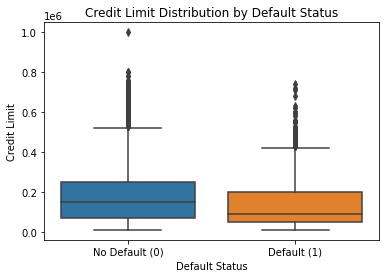

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x='default.payment.next.month',
    y='LIMIT_BAL',
    data=df
)

plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.xlabel('Default Status')
plt.ylabel('Credit Limit')
plt.title('Credit Limit Distribution by Default Status')

plt.show()



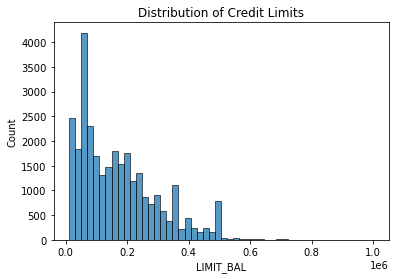

'\nright-skewed credit limits\nmany low-limit cards, few high-limit ones\n'

In [116]:
sns.histplot(df['LIMIT_BAL'], bins=50)
plt.title('Distribution of Credit Limits')
plt.show()

"""
right-skewed credit limits
many low-limit cards, few high-limit ones
"""


In [117]:
"""
The boxplot compares credit limits between borrowers who defaulted and those who did not, where 0 represents non-default and 1 represents default.
The entire distribution of credit limits for defaulters is shifted downward compared to non-defaulters.
The boxplot confirms that borrowers who default generally have lower credit limits than those who do not. While there is some overlap between the two groups, the median and interquartile range for defaulters are consistently lower, indicating that credit limit is a useful predictor of default risk.
"""

'\nThe boxplot compares credit limits between borrowers who defaulted and those who did not, where 0 represents non-default and 1 represents default.\nThe entire distribution of credit limits for defaulters is shifted downward compared to non-defaulters.\nThe boxplot confirms that borrowers who default generally have lower credit limits than those who do not. While there is some overlap between the two groups, the median and interquartile range for defaulters are consistently lower, indicating that credit limit is a useful predictor of default risk.\n'

### 3. Repayment Status vs Default class

In [118]:
df.groupby('default.payment.next.month')['PAY_0'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,-0.211222,0.952464,-2.0,-1.0,0.0,0.0,8.0
1,6636.0,0.668174,1.383252,-2.0,0.0,1.0,2.0,8.0


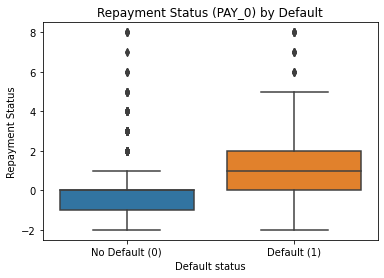

In [119]:
sns.boxplot(
    x='default.payment.next.month',
    y='PAY_0',
    data=df
)
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.title('Repayment Status (PAY_0) by Default')
plt.xlabel('Default status')
plt.ylabel('Repayment Status')
plt.show()


In [120]:
"""
The boxplot shows a clear difference in repayment behavior between borrowers who default and those who do not. Non-defaulters are concentrated around on-time or early repayments, while defaulters exhibit higher repayment delays, reflected in a higher median and wider spread of PAY_0 values. This confirms that recent repayment status is a strong predictor of default risk.

"""

'\nThe boxplot shows a clear difference in repayment behavior between borrowers who default and those who do not. Non-defaulters are concentrated around on-time or early repayments, while defaulters exhibit higher repayment delays, reflected in a higher median and wider spread of PAY_0 values. This confirms that recent repayment status is a strong predictor of default risk.\n\n'

### 4. Bill amounts (debt burden) vs default status
#### Bill amounts capture outstanding debt. Even with the same credit limit, higher unpaid balances can increase default risk.

In [121]:
df.groupby('default.payment.next.month')['BILL_AMT1'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,51994.227273,73577.606694,-165580.0,3677.25,23119.5,69027.0,964511.0
1,6636.0,48509.162297,73782.067220,-6676.0,2987.75,20185.0,59626.5,613860.0


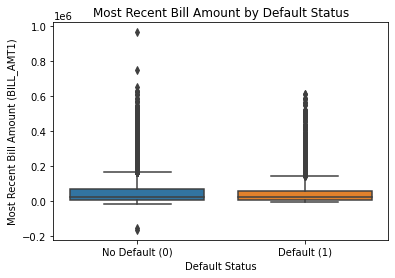

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x='default.payment.next.month',
    y='BILL_AMT1',
    data=df
)

plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.xlabel('Default Status')
plt.ylabel('Most Recent Bill Amount (BILL_AMT1)')
plt.title('Most Recent Bill Amount by Default Status')

plt.show()


In [123]:
"""
The average and median bill amounts for defaulters and non-defaulters are relatively close.
Both groups show high variability and a large number of outliers, indicating wide differences in outstanding balances.
The boxplot shows substantial overlap between defaulters and non-defaulters, with no strong shift in the distribution similar to what we observed for repayment status.
Although non-defaulters have slightly higher upper-range values, the overall separation between the two groups is weak.

The summary statistics and boxplot indicate that bill amounts alone do not strongly distinguish defaulters from non-defaulters. While both groups exhibit wide variation and extreme outliers in outstanding balances, their median and interquartile ranges are largely overlapping. This suggests that bill amount, by itself, is a weaker predictor of default risk compared to recent repayment behavior, though it may still provide complementary information when combined with other features in the model.

"""

'\nThe average and median bill amounts for defaulters and non-defaulters are relatively close.\nBoth groups show high variability and a large number of outliers, indicating wide differences in outstanding balances.\nThe boxplot shows substantial overlap between defaulters and non-defaulters, with no strong shift in the distribution similar to what we observed for repayment status.\nAlthough non-defaulters have slightly higher upper-range values, the overall separation between the two groups is weak.\n\nThe summary statistics and boxplot indicate that bill amounts alone do not strongly distinguish defaulters from non-defaulters. While both groups exhibit wide variation and extreme outliers in outstanding balances, their median and interquartile ranges are largely overlapping. This suggests that bill amount, by itself, is a weaker predictor of default risk compared to recent repayment behavior, though it may still provide complementary information when combined with other features in the

### 5. Age vs default status

In [124]:
df.groupby('default.payment.next.month')['AGE'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,35.417266,9.077355,21.0,28.0,34.0,41.0,79.0
1,6636.0,35.725738,9.693438,21.0,28.0,34.0,42.0,75.0


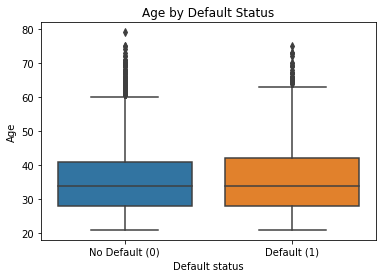

In [125]:
sns.boxplot(
    x='default.payment.next.month',
    y='AGE',
    data=df
)
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.title('Age by Default Status')
plt.xlabel('Default status')
plt.ylabel('Age')
plt.show()


In [126]:
"""
The age distribution for defaulters and non-defaulters is broadly similar, with substantial overlap in both the median and interquartile range. Defaulters tend to be slightly younger on average, but the difference is modest. This suggests that age alone is not a strong predictor of default risk, though it may contribute marginally when combined with financial and repayment features.

"""

'\nThe age distribution for defaulters and non-defaulters is broadly similar, with substantial overlap in both the median and interquartile range. Defaulters tend to be slightly younger on average, but the difference is modest. This suggests that age alone is not a strong predictor of default risk, though it may contribute marginally when combined with financial and repayment features.\n\n'

### 6. Gender vs default status

In [127]:
pd.crosstab(df['SEX'], df['default.payment.next.month'], normalize='index') * 100


default.payment.next.month,0,1
SEX,,
1,75.832773,24.167227
2,79.223719,20.776281


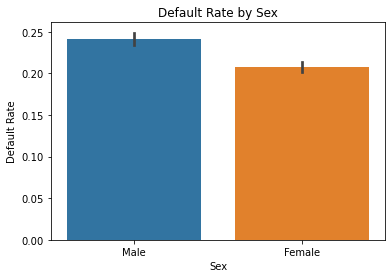

In [128]:
sns.barplot(
    x='SEX',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Default Rate')
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()


In [129]:
"""
The default rates for male and female borrowers are relatively similar, with only a small difference between the two groups. This indicates that sex is not a primary driver of default risk in this dataset, though it may still provide limited additional information when used alongside financial and repayment variables.
"""

'\nThe default rates for male and female borrowers are relatively similar, with only a small difference between the two groups. This indicates that sex is not a primary driver of default risk in this dataset, though it may still provide limited additional information when used alongside financial and repayment variables.\n'

### 7. Default status by education

In [130]:
pd.crosstab(
    df['EDUCATION'],
    df['default.payment.next.month'],
    normalize='index'
) * 100


default.payment.next.month,0,1
EDUCATION,,
0,100.000000,0.000000
1,80.765234,19.234766
2,76.265146,23.734854
3,74.842384,25.157616
4,94.308943,5.691057
5,93.571429,6.428571
6,84.313725,15.686275


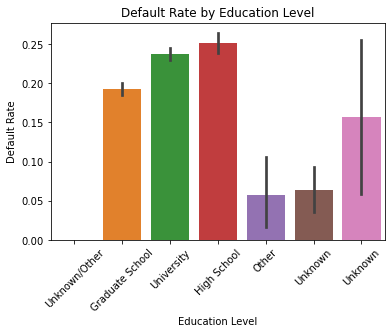

In [131]:
sns.barplot(
    x='EDUCATION',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Default Rate')
plt.xticks(
    ticks=[0, 1, 2, 3, 4, 5, 6],
    labels=[
        'Unknown/Other',
        'Graduate School',
        'University',
        'High School',
        'Other',
        'Unknown',
        'Unknown'
    ],
    rotation=45
)
plt.show()


In [132]:
"""
Default rates vary modestly across education levels, with borrowers having lower formal education showing slightly higher default rates. However, the differences are not large, suggesting that education is a secondary predictor compared to repayment history and credit capacity.

"""

'\nDefault rates vary modestly across education levels, with borrowers having lower formal education showing slightly higher default rates. However, the differences are not large, suggesting that education is a secondary predictor compared to repayment history and credit capacity.\n\n'

In [133]:
### 8. Default status by marriage

In [134]:
pd.crosstab(
    df['MARRIAGE'],
    df['default.payment.next.month'],
    normalize='index'
) * 100


default.payment.next.month,0,1
MARRIAGE,,
0,90.740741,9.259259
1,76.528296,23.471704
2,79.071661,20.928339
3,73.993808,26.006192


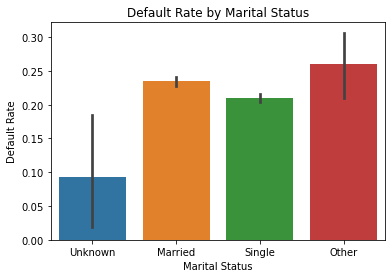

In [135]:
sns.barplot(
    x='MARRIAGE',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Default Rate')
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=['Unknown', 'Married', 'Single', 'Other']
)
plt.show()


In [136]:
"""
Default rates differ slightly by marital status, with single borrowers exhibiting marginally higher default rates. Overall, marital status does not strongly separate defaulters from non-defaulters and is likely to play a supporting role in the predictive model.

"""

'\nDefault rates differ slightly by marital status, with single borrowers exhibiting marginally higher default rates. Overall, marital status does not strongly separate defaulters from non-defaulters and is likely to play a supporting role in the predictive model.\n\n'

In [137]:
## Wrapping up of EDA
""""
Exploratory data analysis on a few x variables against target variable reveals clear differences between borrowers who defaulted and those who did not. Default behavior is moderately imbalanced, with approximately 22% of borrowers defaulting in the following month. Credit capacity, measured by credit limit, shows a strong relationship with default, as defaulters tend to have lower credit limits. Recent repayment behavior is the strongest indicator of default risk, with defaulters exhibiting significantly worse repayment status compared to non-defaulters.
In contrast, bill amounts show substantial overlap between the two groups, suggesting that outstanding balances alone are a weaker predictor of default. Demographic variables such as age, sex, education, and marital status display only modest differences between defaulters and non-defaulters, indicating that they are likely to play a supporting rather than primary role in prediction. Overall, the analysis suggests that repayment history and credit capacity are the most informative features for modeling default risk.

"""
#for slides
""""
Exploratory analysis shows that repayment behavior and credit limits are the strongest indicators of default risk. Defaulters tend to have worse recent repayment status and lower credit limits, while demographic factors such as age, sex, education, and marital status show only modest differences. These insights motivate a predictive modeling approach that prioritizes behavioral and financial variables.
"""

'"\nExploratory analysis shows that repayment behavior and credit limits are the strongest indicators of default risk. Defaulters tend to have worse recent repayment status and lower credit limits, while demographic factors such as age, sex, education, and marital status show only modest differences. These insights motivate a predictive modeling approach that prioritizes behavioral and financial variables.\n'

## Model development

### 1. Logistic regression model -baseline

We first define the target variable and independent variables 
* The target variable represents whether a borrower defaults in the following month. 
* The independent set includes borrower demographics, credit capacity, repayment history, and billing information etc
* Identifier variables that do not contain predictive information are removed.


In [138]:
# Define target variable and independent variables
# Define target variable
y = df['default.payment.next.month']
X = df.drop(columns=['ID', 'default.payment.next.month'])

In [139]:
X.shape, y.shape

# This confirms that the predictors matrix (X) contains 23 independent variables and the target vector (y) contains the binary default outcome for all 30,000 observations.


((30000, 23), (30000,))

In [140]:
# Train test split
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,    # reproducibility
    stratify=y          # keeps same default rate in train and test
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((24000, 23), (6000, 23), (24000,), (6000,))

#### Independent variabes scaling

Since our dataset contains features with different scales (e.g., credit limits, bills, repayment statuses, etc.), it's important to standardize them.

If we train a logistic regression model without scaling, variables with large values may have a stronger influence on the model

To prevent this, we standardize them so that they are on a similar scale. This allows the model to learn from all variables more fairly and improves stability during training.

"""

In [141]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data ONLY
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

X_train_scaled

"""
The scaler is fitted only on the training data to prevent data leakage. 
The test data is transformed using the same parameters learned from the training set.

"""


'\nThe scaler is fitted only on the training data to prevent data leakage. \nThe test data is transformed using the same parameters learned from the training set.\n\n'

In [142]:
# build the logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Train the model on the scaled training data
log_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8078333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000

Confusion Matrix:
 [[4529  144]
 [1009  318]]


In [143]:
### Logistic regression baseline results

"""
The logistic regression model achieved an overall accuracy of 81%. However, because the dataset is imbalanced, accuracy alone is not a reliable indicator of performance.
The model performs very well at identifying non-defaulters (97% recall). However, it performs poorly at identifying defaulters, with a recall of only 24%. This means that the model correctly identifies only 318 out of 1,327 actual defaulters and misses 1,009 defaulters (false negatives).
From a business perspective, false negatives are particularly costly because they represent high-risk customers who are incorrectly predicted as safe. Missing these borrowers could lead to significant financial losses.
The dataset is imbalanced, with significantly fewer defaulters than non-defaulters. In this context, overall accuracy can be misleading. From a business perspective, failing to identify a customer who will default (false negative) can result in financial loss. Therefore, recall for the default class is the most important metric in this analysis. This project prioritizes maximizing recall of defaulters while maintaining reasonable precision.
"""

'\nThe logistic regression model achieved an overall accuracy of 81%. However, because the dataset is imbalanced, accuracy alone is not a reliable indicator of performance.\nThe model performs very well at identifying non-defaulters (97% recall). However, it performs poorly at identifying defaulters, with a recall of only 24%. This means that the model correctly identifies only 318 out of 1,327 actual defaulters and misses 1,009 defaulters (false negatives).\nFrom a business perspective, false negatives are particularly costly because they represent high-risk customers who are incorrectly predicted as safe. Missing these borrowers could lead to significant financial losses.\nThe dataset is imbalanced, with significantly fewer defaulters than non-defaulters. In this context, overall accuracy can be misleading. From a business perspective, failing to identify a customer who will default (false negative) can result in financial loss. Therefore, recall for the default class is the most imp

### 2. Logistic Regression with Class Weights

The baseline model showed very low recall for defaulters (24%), meaning most high-risk borrowers were missed. Since identifying defaulters is the primary business objective, improving recall is critical.

Before moving to a more complex model such as a Decision Tree, we first attempt to improve performance within logistic regression by addressing class imbalance. One common technique for handling class imbalance is adjusting class weights;the model penalizes misclassification of defaulters more heavily. This allows us to test whether handling imbalance alone improves recall before introducing additional model complexity such as decision tree model

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression with class weights to handle imbalance
log_reg_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

log_reg_balanced.fit(X_train_scaled, y_train)

y_pred_balanced = log_reg_balanced.predict(X_test_scaled)

print("Logistic Regression (class_weight='balanced') Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))

Logistic Regression (class_weight='balanced') Results:
Confusion Matrix:
 [[3254 1419]
 [ 504  823]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000



In [145]:
# The balanced logistic regression results
"""
The balanced logistic regression significantly improves recall for defaulters from 24% to 62%. The model now correctly identifies 823 out of 1,327 defaulters, reducing missed defaulters from 1,009 in the baseline model to 504 ie cutting false negatives nearly in half compared to the baseline model.
Although overall accuracy decreases from 81% to 68%, this trade-off is expected when prioritizing the minority class. From a business perspective, reducing false negatives is critical because each missed defaulter represents potential financial loss.
"""

'\nThe balanced logistic regression significantly improves recall for defaulters from 24% to 62%. The model now correctly identifies 823 out of 1,327 defaulters, reducing missed defaulters from 1,009 in the baseline model to 504 ie cutting false negatives nearly in half compared to the baseline model.\nAlthough overall accuracy decreases from 81% to 68%, this trade-off is expected when prioritizing the minority class. From a business perspective, reducing false negatives is critical because each missed defaulter represents potential financial loss.\n'

#### Feature importance of the balanced logistic regression

The coefficients indicate which variables increase or decrease the likelihood of default. Positive coefficients increase default risk, while negative coefficients reduce it.


In [146]:
# Create dataframe of coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg_balanced.coef_[0]
})

# Sort by absolute importance
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10 most important features
coef_df[['Feature', 'Coefficient']].head(10)


,Feature,Coefficient
5,PAY_0,0.590164
11,BILL_AMT1,-0.285593
17,PAY_AMT1,-0.184645
18,PAY_AMT2,-0.160172
0,LIMIT_BAL,-0.136679
6,PAY_2,0.101266
2,EDUCATION,-0.094105
7,PAY_3,0.090108
4,AGE,0.079707
12,BILL_AMT2,0.079305


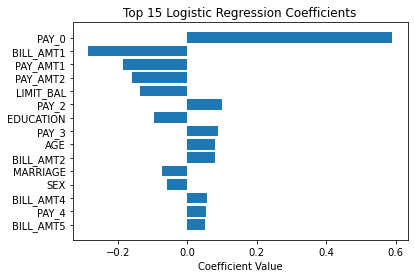

In [147]:
# Display top 10 most important features
coef_df[['Feature', 'Coefficient']].head(10)

import matplotlib.pyplot as plt

top_features = coef_df[['Feature', 'Coefficient']].head(15)

plt.figure()
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.gca().invert_yaxis()
plt.title("Top 15 Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.show()

In [148]:
# # The features importance results
"""
The most influential predictor of default is recent repayment status (PAY_0), which reflects whether a borrower has recently delayed payments. Higher values indicate more severe payment delays, strongly increasing default risk.
Other repayment history variables (PAY_2, PAY_3) also contribute positively to default risk, reinforcing that recent delinquency is a strong warning signal.
In contrast, higher recent payment amounts (PAY_AMT1, PAY_AMT2) and higher credit limits (LIMIT_BAL) are associated with lower default risk. This suggests that borrowers who maintain stronger repayment behavior and have greater credit capacity are less likely to default.

#### Key Variable Groups

**Repayment Status Variables**
- PAY_0: Repayment status in September (most recent month before default)
- PAY_2: Repayment status in August
- PAY_3: Repayment status in July  

These variables capture recent payment delays.

**Billing and Payment Variables**
- BILL_AMT1, BILL_AMT2: Monthly bill statement amounts  
- PAY_AMT1, PAY_AMT2: Actual payment amounts made  

These reflect outstanding balances and repayment behavior.

**Customer Characteristics**
- LIMIT_BAL: Total credit limit granted  
- AGE: Customer age  
- EDUCATION, SEX, MARRIAGE: Demographic attributes 


Overall, the model confirms that;
1. Recent repayment behavior is the strongest driver of default risk
2. Higher credit limit reduced default risk (negative coefficient)

"""

'\nThe most influential predictor of default is recent repayment status (PAY_0), which reflects whether a borrower has recently delayed payments. Higher values indicate more severe payment delays, strongly increasing default risk.\nOther repayment history variables (PAY_2, PAY_3) also contribute positively to default risk, reinforcing that recent delinquency is a strong warning signal.\nIn contrast, higher recent payment amounts (PAY_AMT1, PAY_AMT2) and higher credit limits (LIMIT_BAL) are associated with lower default risk. This suggests that borrowers who maintain stronger repayment behavior and have greater credit capacity are less likely to default.\n\n#### Key Variable Groups\n\n**Repayment Status Variables**\n- PAY_0: Repayment status in September (most recent month before default)\n- PAY_2: Repayment status in August\n- PAY_3: Repayment status in July  \n\nThese variables capture recent payment delays.\n\n**Billing and Payment Variables**\n- BILL_AMT1, BILL_AMT2: Monthly bill st

### 3. Building the decision tree model

After improving logistic regression by addressing class imbalance, we next evaluate a Decision Tree model. Unlike logistic regression, which assumes a linear relationship between features and the target, Decision Trees can capture nonlinear patterns and complex feature interactions.

This allows us to assess whether a more flexible, nonparametric model can further improve recall for defaulters.

In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Train model
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Accuracy: 0.7145

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      4673
           1       0.37      0.41      0.39      1327

    accuracy                           0.71      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg       0.73      0.71      0.72      6000


Confusion Matrix:
 [[3741  932]
 [ 781  546]]


In [150]:
## Decision Tree Results
"""
The Decision Tree model achieved an overall accuracy of 71%. Recall for defaulters improved to 41%, compared to 24% in the baseline logistic regression. This reduces missed defaulters from 1,009 to 781.
However, when compared to the balanced logistic regression model (62% recall), the default Decision Tree does not perform as well at identifying high-risk borrowers.
Although the tree is capable of capturing nonlinear relationships, it does not yet outperform logistic regression when class imbalance is properly addressed. Therefore, we next retrain the Decision Tree using class weights to determine whether imbalance handling can further improve recall.
"""

'\nThe Decision Tree model achieved an overall accuracy of 71%. Recall for defaulters improved to 41%, compared to 24% in the baseline logistic regression. This reduces missed defaulters from 1,009 to 781.\nHowever, when compared to the balanced logistic regression model (62% recall), the default Decision Tree does not perform as well at identifying high-risk borrowers.\nAlthough the tree is capable of capturing nonlinear relationships, it does not yet outperform logistic regression when class imbalance is properly addressed. Therefore, we next retrain the Decision Tree using class weights to determine whether imbalance handling can further improve recall.\n'

### 4. Decision Tree with Class Weights

The default Decision Tree improved recall compared to the baseline logistic regression, but it did not outperform the balanced logistic regression model. Since class imbalance has proven to significantly impact performance, we retrain the Decision Tree using `class_weight='balanced'`.

This adjustment penalizes misclassification of defaulters more heavily and allows us to assess whether combining model flexibility with imbalance handling further improves recall.


In [151]:
# Decision Tree with class weight balancing
dt_balanced = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'
)

# Train model
dt_balanced.fit(X_train, y_train)

# Predictions
y_pred_dt_balanced = dt_balanced.predict(X_test)

# Evaluation
print("Decision Tree (class_weight='balanced') Results")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt_balanced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt_balanced))


Decision Tree (class_weight='balanced') Results
Accuracy: 0.7288333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      4673
           1       0.38      0.38      0.38      1327

    accuracy                           0.73      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.73      0.73      0.73      6000


Confusion Matrix:
 [[3873  800]
 [ 827  500]]


In [152]:
"""
The balanced Decision Tree achieved an accuracy of 73%. However, recall for defaulters decreased to 38%, identifying only 500 out of 1,327 defaulters and missing 827 high-risk borrowers.
When compared to the balanced logistic regression model (62% recall), the Decision Tree performs substantially worse at detecting defaulters. Although the tree captures nonlinear relationships, increasing model complexity does not improve minority class detection in this case.
These results suggest that addressing class imbalance has a greater impact on recall than switching to a more flexible model.
"""

'\nThe balanced Decision Tree achieved an accuracy of 73%. However, recall for defaulters decreased to 38%, identifying only 500 out of 1,327 defaulters and missing 827 high-risk borrowers.\nWhen compared to the balanced logistic regression model (62% recall), the Decision Tree performs substantially worse at detecting defaulters. Although the tree captures nonlinear relationships, increasing model complexity does not improve minority class detection in this case.\nThese results suggest that addressing class imbalance has a greater impact on recall than switching to a more flexible model.\n'

## Final model selection

Among all models evaluated, the balanced logistic regression achieved the highest recall for defaulters (62%), outperforming the baseline logistic regression (24%) and both Decision Tree models (41% and 38%).

Since the primary objective is to identify high-risk borrowers and reduce financial losses from missed defaults, recall was prioritized. The balanced model reduces missed defaulters from 1,009 to 504, cutting false negatives nearly in half.

Final Model Performance:
- Recall (Defaulters): 62%
- Precision (Defaulters): 37%
- Accuracy: 68%

Given its superior ability to detect default risk, the balanced logistic regression is selected as the final model.

#### Limitations

Improving recall comes at the expense of precision, meaning some low-risk borrowers may be incorrectly flagged as high-risk. In practice, this could lead to unnecessary review or stricter credit conditions for certain customers.

Additionally, the model relies on historical repayment behavior. Changes in economic conditions or customer behavior may affect future performance, requiring ongoing monitoring and recalibration.

## Business recommendations

The analysis shows that recent repayment behavior is the strongest indicator of future default. Borrowers with recent payment delays are significantly more likely to default in the following month.

Based on these findings, the bank/financial institutions should:

- Closely monitor customers with recent missed or delayed payments, as they exhibit significantly higher default risk.
- Implement early intervention strategies such as reminder notifications or repayment support for at-risk customers.
-  Carefully review credit limits, recognizing that customers with stronger credit profiles and higher limits tend to demonstrate lower default risk.
-  Use dynamic credit limit adjustments as part of ongoing risk management, rewarding consistent repayment behavior while reducing exposure to higher-risk borrowers.
-  Deploy the model as a risk-screening tool to flag high-risk accounts for further review rather than relying on automatic rejection.

By proactively identifying borrowers who show early warning signs, the bank can reduce credit losses and improve overall portfolio risk management.
